# Symbolic Regression

This example combines neural differential equations with regularised evolution to discover the equations

$\frac{\mathrm{d} x}{\mathrm{d} t}(t) = \frac{y(t)}{1 + y(t)}$

$\frac{\mathrm{d} y}{\mathrm{d} t}(t) = \frac{-x(t)}{1 + x(t)}$

directly from data.

**References:**

This example appears as an example in:

```bibtex
@phdthesis{kidger2021on,
    title={{O}n {N}eural {D}ifferential {E}quations},
    author={Patrick Kidger},
    year={2021},
    school={University of Oxford},
}
```

Whilst drawing heavy inspiration from:

```bibtex
@inproceedings{cranmer2020discovering,
    title={{D}iscovering {S}ymbolic {M}odels from {D}eep {L}earning with {I}nductive
           {B}iases},
    author={Cranmer, Miles and Sanchez Gonzalez, Alvaro and Battaglia, Peter and
            Xu, Rui and Cranmer, Kyle and Spergel, David and Ho, Shirley},
    booktitle={Advances in Neural Information Processing Systems},
    publisher={Curran Associates, Inc.},
    year={2020},
}

@software{cranmer2020pysr,
    title={PySR: Fast \& Parallelized Symbolic Regression in Python/Julia},
    author={Miles Cranmer},
    publisher={Zenodo},
    url={http://doi.org/10.5281/zenodo.4041459},
    year={2020},
}
```

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/symbolic_regression.ipynb).

In [1]:
import tempfile
from typing import List

import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import pysr  # https://github.com/MilesCranmer/PySR
import sympy


# Note that PySR, which we use for symbolic regression, uses Julia as a backend.
# You'll need to install a recent version of Julia if you don't have one.
# (And can get funny errors if you have a too-old version of Julia already.)
# You may also need to restart Python after running `pysr.install()` the first time.
pysr.silence_julia_warning()
pysr.install(quiet=True)

Now for a bunch of helpers. We'll use these in a moment; skip over them for now.

In [2]:
def quantise(expr, quantise_to):
    if isinstance(expr, sympy.Float):
        return expr.func(round(float(expr) / quantise_to) * quantise_to)
    elif isinstance(expr, sympy.Symbol):
        return expr
    else:
        return expr.func(*[quantise(arg, quantise_to) for arg in expr.args])


class SymbolicFn(eqx.Module):
    fn: callable
    parameters: jnp.ndarray

    def __call__(self, x):
        # Dummy batch/unbatching. PySR assumes its JAX'd symbolic functions act on
        # tensors with a single batch dimension.
        return jnp.squeeze(self.fn(x[None], self.parameters))


class Stack(eqx.Module):
    modules: List[eqx.Module]

    def __call__(self, x):
        return jnp.stack([module(x) for module in self.modules], axis=-1)


def expr_size(expr):
    return sum(expr_size(v) for v in expr.args) + 1


def _replace_parameters(expr, parameters, i_ref):
    if isinstance(expr, sympy.Float):
        i_ref[0] += 1
        return expr.func(parameters[i_ref[0]])
    elif isinstance(expr, sympy.Symbol):
        return expr
    else:
        return expr.func(
            *[_replace_parameters(arg, parameters, i_ref) for arg in expr.args]
        )


def replace_parameters(expr, parameters):
    i_ref = [-1]  # Distinctly sketchy approach to making this conversion.
    return _replace_parameters(expr, parameters, i_ref)

Okay, let's get started.

We start by running the [Neural ODE example](./neural_ode.ipynb).
Then we extract the learnt neural vector field, and symbolically regress across this.
Finally we fine-tune the resulting symbolic expression.


In [3]:
def main(
    symbolic_dataset_size=2000,
    symbolic_num_populations=100,
    symbolic_population_size=20,
    symbolic_migration_steps=4,
    symbolic_mutation_steps=30,
    symbolic_descent_steps=50,
    pareto_coefficient=2,
    fine_tuning_steps=500,
    fine_tuning_lr=3e-3,
    quantise_to=0.01,
):
    #
    # First obtain a neural approximation to the dynamics.
    # We begin by running the previous example.
    #

    # Runs the Neural ODE example.
    # This defines the variables `ts`, `ys`, `model`.
    print("Training neural differential equation.")
    %run neural_ode.ipynb

    #
    # Now symbolically regress across the learnt vector field, to obtain a Pareto
    # frontier of symbolic equations, that trades loss against complexity of the
    # equation. Select the "best" from this frontier.
    #

    print("Symbolically regressing across the vector field.")
    vector_field = model.func.mlp  # noqa: F821
    dataset_size, length_size, data_size = ys.shape  # noqa: F821
    in_ = ys.reshape(dataset_size * length_size, data_size)  # noqa: F821
    in_ = in_[:symbolic_dataset_size]
    out = jax.vmap(vector_field)(in_)
    with tempfile.TemporaryDirectory() as tempdir:
        symbolic_regressor = pysr.PySRRegressor(
            niterations=symbolic_migration_steps,
            ncyclesperiteration=symbolic_mutation_steps,
            populations=symbolic_num_populations,
            npop=symbolic_population_size,
            optimizer_iterations=symbolic_descent_steps,
            optimizer_nrestarts=1,
            procs=1,
            verbosity=0,
            tempdir=tempdir,
            temp_equation_file=True,
            output_jax_format=True,
        )
        symbolic_regressor.fit(in_, out)
        best_equations = symbolic_regressor.get_best()
        expressions = [b.sympy_format for b in best_equations]
        symbolic_fns = [
            SymbolicFn(b.jax_format["callable"], b.jax_format["parameters"])
            for b in best_equations
        ]

    #
    # Now the constants in this expression have been optimised for regressing across
    # the neural vector field. This was good enough to obtain the symbolic expression,
    # but won't quite be perfect -- some of the constants will be slightly off.
    #
    # To fix this we now plug our symbolic function back into the original dataset
    # and apply gradient descent.
    #

    print("Optimising symbolic expression.")

    symbolic_fn = Stack(symbolic_fns)
    flat, treedef = jax.tree_flatten(
        model, is_leaf=lambda x: x is model.func.mlp  # noqa: F821
    )
    flat = [symbolic_fn if f is model.func.mlp else f for f in flat]  # noqa: F821
    symbolic_model = jax.tree_unflatten(treedef, flat)

    @eqx.filter_grad
    def grad_loss(symbolic_model):
        vmap_model = jax.vmap(symbolic_model, in_axes=(None, 0))
        pred_ys = vmap_model(ts, ys[:, 0])  # noqa: F821
        return jnp.mean((ys - pred_ys) ** 2)  # noqa: F821

    optim = optax.adam(fine_tuning_lr)
    opt_state = optim.init(eqx.filter(symbolic_model, eqx.is_inexact_array))

    @eqx.filter_jit
    def make_step(symbolic_model, opt_state):
        grads = grad_loss(symbolic_model)
        updates, opt_state = optim.update(grads, opt_state)
        symbolic_model = eqx.apply_updates(symbolic_model, updates)
        return symbolic_model, opt_state

    for _ in range(fine_tuning_steps):
        symbolic_model, opt_state = make_step(symbolic_model, opt_state)

    #
    # Finally we round each constant to the nearest multiple of `quantise_to`.
    #

    trained_expressions = []
    for module, expression in zip(symbolic_model.func.mlp.modules, expressions):
        expression = replace_parameters(expression, module.parameters.tolist())
        expression = quantise(expression, quantise_to)
        trained_expressions.append(expression)

    print(f"Expressions found: {trained_expressions}")

Training neural differential equation.
Step: 0, Loss: 0.1665748506784439, Computation time: 24.18653130531311
Step: 100, Loss: 0.011155527085065842, Computation time: 0.09058809280395508
Step: 200, Loss: 0.006481727119535208, Computation time: 0.0928184986114502
Step: 300, Loss: 0.001382559770718217, Computation time: 0.09850335121154785
Step: 400, Loss: 0.001073717838153243, Computation time: 0.09830045700073242
Step: 499, Loss: 0.0007992316968739033, Computation time: 0.09975647926330566
Step: 0, Loss: 0.02832634374499321, Computation time: 24.61294913291931
Step: 100, Loss: 0.005440382286906242, Computation time: 0.40324854850769043
Step: 200, Loss: 0.004360489547252655, Computation time: 0.43680524826049805
Step: 300, Loss: 0.001799552352167666, Computation time: 0.4346010684967041
Step: 400, Loss: 0.0017023109830915928, Computation time: 0.437793493270874
Step: 499, Loss: 0.0011540694395080209, Computation time: 0.42920470237731934


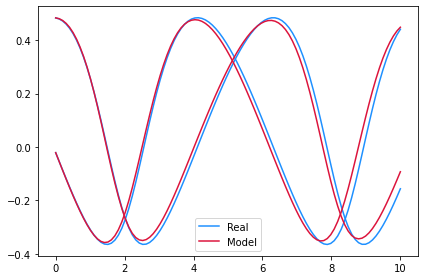

Symbolically regressing across the vector field.


Optimising symbolic expression.
Expressions found: [x1/(x1 + 1.0), x0/(-x0 - 1.0)]


In [4]:
main()